In [1]:
# Import libraries
import scipy
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from pandas import DataFrame
from pandas import Series
from pandas import concat


# Loading Data

In [2]:
####### Loading data for batteries #########

def data_loading(filename, inrelevant_features):
    raw_data = pd.read_json(filename)
    df = raw_data.copy()
    df = df.T
    
    useful_df = df.drop(inrelevant_features, axis = 1)
    
    ### index 
    useful_df.index = range(len(useful_df))
    useful_df.index = useful_df.index
    
    ## change from df to series
    series = useful_df.squeeze()
    
    return useful_df, series
    
    

In [3]:
# loading data test
# obtain the capacity feature


def getValue(x):
    return x[0]


filename_5 = 'B0005_discharge.json'
filename_6 = 'B0006_discharge.json'
filename_7 = 'B0007_discharge.json'
filename_18 = 'B0018_discharge.json'
inre_features = ['date_time', 'voltage_battery', 'current_battery', 'temp_battery', 'amb_temp', 'current_load', 'voltage_load', 'time']
capacity_df_5, _ = data_loading(filename_5, inre_features)
capacity_df_6, _ = data_loading(filename_6, inre_features)
capacity_df_7, _ = data_loading(filename_7, inre_features)
capacity_df_18, _ = data_loading(filename_18, inre_features)
capacity_df_5['capacity'] = capacity_df_5['capacity'].map(getValue)
capacity_df_6['capacity'] = capacity_df_6['capacity'].map(getValue)
capacity_df_7['capacity'] = capacity_df_7['capacity'].map(getValue)
capacity_df_18['capacity'] = capacity_df_18['capacity'].map(getValue)

In [4]:
capacity_df_5

,capacity
0,1.856487
1,1.846327
2,1.835349
3,1.835263
4,1.834646
...,...
163,1.293464
164,1.288003
165,1.287453
166,1.309015


In [5]:
### draw one time_series plot ###

def timeseries(x_axis, y_axis, x_label, y_label):
    """_summary_

    Args:
        x_axis (_type_): _description_
        y_axis (_type_): _description_
        x_label (_type_): _description_
        y_label (_type_): _description_
    """
    plt.figure(figsize=(10,6))
    plt.plot(x_axis, y_axis, color='black')
    plt.xlabel(x_label, {'fontsize':12})
    plt.ylabel(y_label, {'fontsize':12})
    

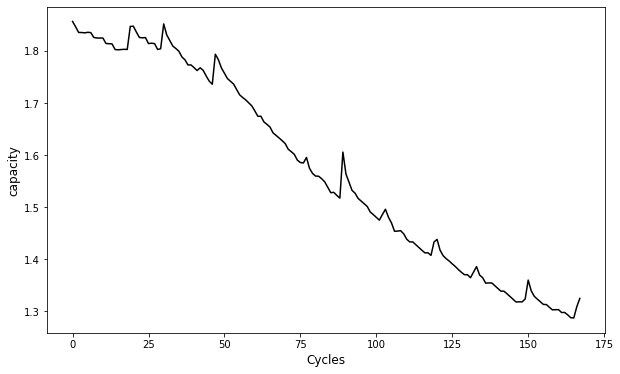

In [6]:
timeseries(capacity_df_5.index, capacity_df_5['capacity'], 'Cycles', 'capacity')

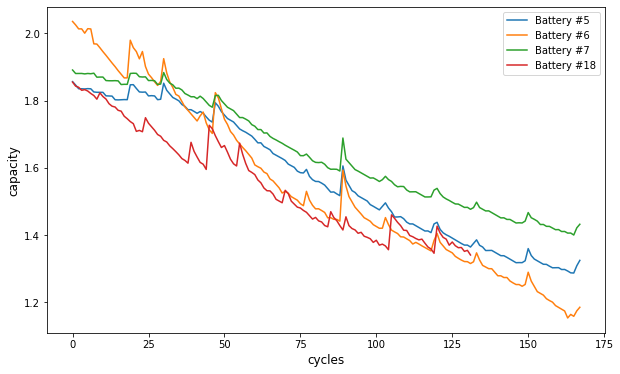

In [7]:
# multiple batteries
plt.figure(figsize=(10,6))
plt.plot(capacity_df_5.index, capacity_df_5['capacity'], label='Battery #5')
plt.plot(capacity_df_6.index, capacity_df_6['capacity'], label ='Battery #6')
plt.plot(capacity_df_7.index, capacity_df_7['capacity'], label = 'Battery #7')
plt.plot(capacity_df_18.index, capacity_df_18['capacity'], label = 'Battery #18')
plt.xlabel('cycles', {'fontsize':12})
plt.ylabel('capacity', {'fontsize':12})
plt.legend()
plt.show()

# Data Processing

### 1. transform the data into stationary

In [8]:
#### Detecting non-stationarity statistically ######
from statsmodels.tsa.stattools import adfuller 
def detect_stationarity(dataset):
    test_results = adfuller(dataset)
    return test_results

c:\Users\haidlu\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
c:\Users\haidlu\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [9]:
test_results = detect_stationarity(capacity_df_5["capacity"])
print(f"p-value: {test_results[1]}")

p-value: 0.8869061026357303


In [10]:
##### def: transform the data into stationary ##############

def transform_into_stationary(df):
    df = df.diff()
    df = df.dropna()
    return df

In [11]:
#### def: reverse diff()
def inverse_dif(observations, diff):
    dif = diff 
    #dif.index -= 1
    #observations.index += 1
    obs = observations
    obs.index += 1 
    inverse = obs + dif
    return inverse

In [12]:
capacity_df_5

,capacity
0,1.856487
1,1.846327
2,1.835349
3,1.835263
4,1.834646
...,...
163,1.293464
164,1.288003
165,1.287453
166,1.309015


In [13]:
dif = transform_into_stationary(capacity_df_5)

In [14]:
test_results = detect_stationarity(dif["capacity"])
print(f"p-value: {test_results[1]}")

p-value: 1.7041928511238572e-19


In [15]:
dif

,capacity
1,-0.010160
2,-0.010978
3,-0.000087
4,-0.000617
5,0.001016
...,...
163,-0.004610
164,-0.005460
165,-0.000551
166,0.021563


### 2. Normalization

In [16]:
###### Normalization #########
def normalization(dataset):
    """ to normalize the dataset between (0, 1)
    input a dataframe, output the normalized dataframe
    Args:
        dataset (dataframe): the data to be normalized
    """
    scaler = MinMaxScaler(feature_range=(0, 1))
    input_scaler = scaler.fit(dataset.values)
    norm_data = input_scaler.transform(dataset.values)
    norm_data = pd.DataFrame(norm_data)
    return norm_data


In [17]:
### test for normalization ####
norm_data = normalization(dif)

In [18]:
scaler = MinMaxScaler(feature_range=(0, 1))
input_scaler = scaler.fit(dif.values)
norm_data = input_scaler.transform(dif.values)
norm_data = pd.DataFrame(norm_data)

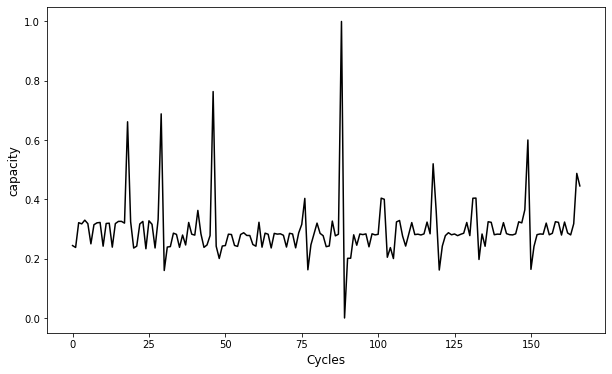

In [19]:
norm_data.columns=['capacity']
timeseries(norm_data.index, norm_data['capacity'], 'Cycles', 'capacity')

In [20]:
norm_data

,capacity
0,0.244121
1,0.237844
2,0.321429
3,0.317359
4,0.329893
...,...
162,0.286716
163,0.280190
164,0.317867
165,0.487577


### 3. Divide the dataset into train and test

In [21]:
########## def: Divide the dataset into train and test ##########
def divide_train_test(dataset, split_fraction):
    train_length = int(split_fraction * int(dataset.shape[0]))
    train_data = dataset.loc[0: train_length - 1]
    test_data = dataset.loc[train_length : ]
    return train_data, test_data
    
def divide_train_test_index(dataset, train_index, test_index):
    train_data = dataset[train_index]
    test_data = dataset[test_index]
    train_data = pd.DataFrame(train_data)
    test_data = pd.DataFrame(test_data)
    test_data.index += train_index.size
    return train_data, test_data

In [22]:
train_data, test_data = divide_train_test(norm_data, split_fraction=0.8)


In [23]:
print(train_data)

     capacity
0    0.244121
1    0.237844
2    0.321429
3    0.317359
4    0.329893
..        ...
128  0.285843
129  0.322062
130  0.277789
131  0.403877
132  0.404361

[133 rows x 1 columns]


In [24]:
print(test_data)

     capacity
133  0.197296
134  0.283206
135  0.241814
136  0.324548
137  0.322572
138  0.280737
139  0.282757
140  0.282204
141  0.321505
142  0.284429
143  0.280942
144  0.280088
145  0.283709
146  0.324376
147  0.320764
148  0.364913
149  0.600287
150  0.164070
151  0.241497
152  0.281001
153  0.283413
154  0.282504
155  0.319999
156  0.280606
157  0.285540
158  0.324584
159  0.322499
160  0.279709
161  0.323525
162  0.286716
163  0.280190
164  0.317867
165  0.487577
166  0.445376


Dimension of train data:  (133, 1)
Dimension of test data:  (34, 1)


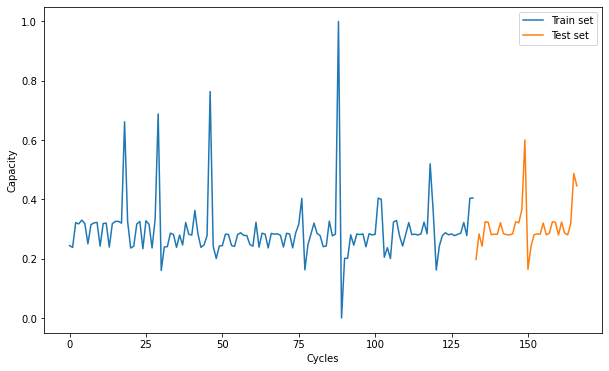

In [24]:
########################## Plotting dataset #######################

plt.figure(figsize = (10, 6))
plt.plot(train_data)
plt.plot(test_data)
plt.xlabel('Cycles')
plt.ylabel('Capacity')
plt.legend(['Train set', 'Test set'], loc='upper right')
print('Dimension of train data: ',train_data.shape)
print('Dimension of test data: ', test_data.shape)



In [25]:
def plot_train_test(train_data, test_data):
    plt.figure(figsize = (10, 6))
    plt.plot(train_data)
    plt.plot(test_data)
    plt.xlabel('Cycles')
    plt.ylabel('Capacity')
    plt.legend(['Train set', 'Test set'], loc='upper right')
    print('Dimension of train data: ',train_data.shape)
    print('Dimension of test data: ', test_data.shape)

### 4. Data Preparation for Model

In [26]:
####### Timeseries dataset from array example #######

def timeseries_dataset_preparation(dataset_array, look_back=1):
    """
    
    Creates tensorflow timeseries dataset from numpy array to be used in model.fit(). 
    
    This function creates a dataset where each element is a tuple `(inputs, targets)` where:
    -- `inputs` (data_X) is a Tensor of shape `(batch_size, look_back, 1)` containing the `look_back` 
    past values of the timeseries for each sample.
    -- `targets` (data_Y) is a Tensor of shape `(batch_size, 1)` containing the future value of the timeseries 
    for each sample.

    Args:
        dataset_array (np.array): array with the shape `(num_time_steps)`.
        look_back (int): length of the input sequence (in number of timesteps).

    Returns:
        A tf.data.Dataset instance, data_X, data_Y
        
    Notes: 
    1) This function requires tensorflow imorted as tf.
    2) It reshapes the dataset to be [samples, time steps, features].
    3) Use 'ds' as 'model.fit(ds,...)'.
    
    """
    num_samples = dataset_array.shape[0] - look_back
    ds_input_data = dataset_array
    ds_targets = dataset_array[look_back:] 

    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
    ds_input_data, ds_targets, sequence_length=look_back, batch_size=num_samples)
    
    # Exctract data_X and data_Y
    for data_X, data_Y in ds:
        data_X = data_X.numpy()
        data_Y = data_Y.numpy()
        return ds, data_X, data_Y
#---------------------------------

In [27]:
def timeseries_dataset_preparation(dataset_array, look_back=1):
    num_samples = dataset_array.shape[0] - look_back
    ds_input_data = dataset_array
    ds_targets = dataset_array[look_back:] 
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
    ds_input_data, ds_targets, sequence_length=look_back, batch_size=num_samples)
    for data_X, data_Y in ds:
        data_X = data_X.numpy()
        data_Y = data_Y.numpy()
        return ds, data_X, data_Y


In [28]:
## timeseries_dataset_preparation test
train_ds, train_data_X, train_data_Y = timeseries_dataset_preparation(train_data, 10)
print(train_data_X.shape)
test_ds, test_data_X, test_data_Y = timeseries_dataset_preparation(test_data, 10)
print(test_data_X.shape)


(123, 10, 1)
(24, 10, 1)


In [29]:
test_data_Y

array([[0.28094215],
       [0.28008809],
       [0.28370882],
       [0.32437588],
       [0.32076361],
       [0.36491302],
       [0.60028712],
       [0.16407006],
       [0.24149717],
       [0.28100137],
       [0.28341343],
       [0.28250375],
       [0.31999873],
       [0.28060583],
       [0.28554044],
       [0.32458425],
       [0.32249873],
       [0.27970873],
       [0.32352509],
       [0.28671604],
       [0.28019024],
       [0.31786676],
       [0.48757713],
       [0.44537632]])

In [29]:
test_data

,capacity
133,0.197296
134,0.283206
135,0.241814
136,0.324548
137,0.322572
138,0.280737
139,0.282757
140,0.282204
141,0.321505
142,0.284429


# Building Model

In [30]:
# Create LSTM model
def create_model(units, X_train):
    model = Sequential()
    model.add(LSTM(units,
                   return_sequences = True,
                   input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.1))
    model.add(LSTM(units = units))
    model.add(Dropout(0.1))
    model.add(Dense(units = 1))
    # Compile model
    model.compile(loss='mse', optimizer='adam')
    return model
    

In [31]:
def fit_model(model, train_data_X, train_data_Y):
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience = 10)
    history = model.fit(train_data_X, train_data_Y,
                        epochs = 200,
                        validation_split=0.2,
                        batch_size = 8,
                        shuffle = False,
                        callbacks=[early_stop])
    return history

In [32]:
model_lstm = create_model(32, train_data_X)

In [33]:
history_lstm = fit_model(model_lstm, train_data_X,  train_data_Y)

Epoch 1/200
13/13 [==============================] - 5s 86ms/step - loss: 0.0399 - val_loss: 0.0072
Epoch 2/200
13/13 [==============================] - 0s 13ms/step - loss: 0.0173 - val_loss: 0.0064
Epoch 3/200
13/13 [==============================] - 0s 13ms/step - loss: 0.0145 - val_loss: 0.0046
Epoch 4/200
13/13 [==============================] - 0s 13ms/step - loss: 0.0147 - val_loss: 0.0047
Epoch 5/200
13/13 [==============================] - 0s 13ms/step - loss: 0.0151 - val_loss: 0.0047
Epoch 6/200
13/13 [==============================] - 0s 12ms/step - loss: 0.0141 - val_loss: 0.0047
Epoch 7/200
13/13 [==============================] - 0s 13ms/step - loss: 0.0137 - val_loss: 0.0049
Epoch 8/200
13/13 [==============================] - 0s 12ms/step - loss: 0.0155 - val_loss: 0.0046
Epoch 9/200
13/13 [==============================] - 0s 14ms/step - loss: 0.0144 - val_loss: 0.0049
Epoch 10/200
13/13 [==============================] - 0s 13ms/step - loss: 0.0150 - val_loss: 0.0047

In [34]:
#### Plotting function ######
# Plot train loss and validation loss
def plot_loss (history):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('cycles')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')

In [35]:
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 32)            4352      
                                                                 
 dropout (Dropout)           (None, 10, 32)            0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________


In [36]:
train_data_Y = scaler.inverse_transform(train_data_Y)
test_data_Y = scaler.inverse_transform(test_data_Y)

## Make prediction

In [37]:
# Make prediction
def prediction(model, test_data_X):
    prediction = model.predict(test_data_X)
    prediction = scaler.inverse_transform(prediction)
    return prediction

#prediction_lstm = prediction(model_lstm)

In [38]:
prediction_lstm = prediction(model_lstm, test_data_X)

In [49]:
test_data_X

array([[[0.19729638],
        [0.28320639],
        [0.24181399],
        [0.32454756],
        [0.32257188],
        [0.28073741],
        [0.28275671],
        [0.28220406],
        [0.32150455],
        [0.2844294 ]],

       [[0.28320639],
        [0.24181399],
        [0.32454756],
        [0.32257188],
        [0.28073741],
        [0.28275671],
        [0.28220406],
        [0.32150455],
        [0.2844294 ],
        [0.28094215]],

       [[0.24181399],
        [0.32454756],
        [0.32257188],
        [0.28073741],
        [0.28275671],
        [0.28220406],
        [0.32150455],
        [0.2844294 ],
        [0.28094215],
        [0.28008809]],

       [[0.32454756],
        [0.32257188],
        [0.28073741],
        [0.28275671],
        [0.28220406],
        [0.32150455],
        [0.2844294 ],
        [0.28094215],
        [0.28008809],
        [0.28370882]],

       [[0.32257188],
        [0.28073741],
        [0.28275671],
        [0.28220406],
        [0.32150455],
  

In [51]:
test_data_X.shape

(24, 10, 1)

In [39]:
test_data_Y

array([[-5.36224506e-03],
       [-5.47353169e-03],
       [-5.00174038e-03],
       [ 2.97284820e-04],
       [-1.73403561e-04],
       [ 5.57938214e-03],
       [ 3.62492544e-02],
       [-2.05909899e-02],
       [-1.05020303e-02],
       [-5.35452901e-03],
       [-5.04023075e-03],
       [-5.15876462e-03],
       [-2.73068688e-04],
       [-5.40606875e-03],
       [-4.76307605e-03],
       [ 3.24437263e-04],
       [ 5.26879617e-05],
       [-5.52296322e-03],
       [ 1.86425042e-04],
       [-4.60989185e-03],
       [-5.46022123e-03],
       [-5.50870481e-04],
       [ 2.15628421e-02],
       [ 1.60639644e-02]])

In [40]:
prediction_lstm

array([[-0.00537075],
       [-0.00501482],
       [-0.00498156],
       [-0.00482641],
       [-0.00496854],
       [-0.00506738],
       [-0.00498396],
       [-0.00484286],
       [-0.00444801],
       [-0.00428328],
       [-0.00410342],
       [-0.0039999 ],
       [-0.00396168],
       [-0.00398457],
       [-0.00414545],
       [-0.00430336],
       [-0.00460977],
       [-0.00566779],
       [-0.00514366],
       [-0.00491638],
       [-0.00481846],
       [-0.00474479],
       [-0.00469304],
       [-0.004757  ]], dtype=float32)

In [41]:
print(test_data_Y.shape)
print(prediction_lstm.shape)

(24, 1)
(24, 1)


In [42]:
capacity_df_5

,capacity
0,1.856487
1,1.846327
2,1.835349
3,1.835263
4,1.834646
...,...
163,1.293464
164,1.288003
165,1.287453
166,1.309015


In [43]:
len = len(test_data_Y)
observation = capacity_df_5[-1-len: -1]
predictict = prediction_lstm + observation
y_test = test_data_Y + observation

In [44]:
# Plot true future vs prediction
def plot_future(prediction, y_test):
    plt.figure(figsize=(10, 6))
    range_future = prediction.shape[0]
    plt.plot(np.arange(range_future), np.array(y_test), 
             label='True Future')     
    plt.plot(np.arange(range_future),np.array(prediction),
            label='Prediction')
    plt.legend(loc='upper left')
    plt.xlabel('Cycles')
    plt.ylabel('Capacity')
    

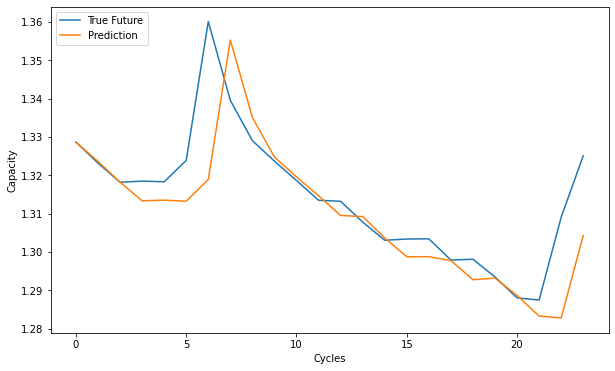

In [45]:
plot_future(predictict, y_test)

In [46]:
############# Calculate RMSE and MAE ##################
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    print(model_name + ':')
    print('Mean Absolute Error: ', mae[0])
    print('Root Mean Square Error: ', rmse[0])
    print('')

In [47]:
evaluate_prediction(predictict, y_test, 'LSTM')

LSTM:
Mean Absolute Error:  0.006665299912383256
Root Mean Square Error:  0.011866591109294607



In [48]:
model_lstm.save('model', save_format='tf')

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


### Complete Example

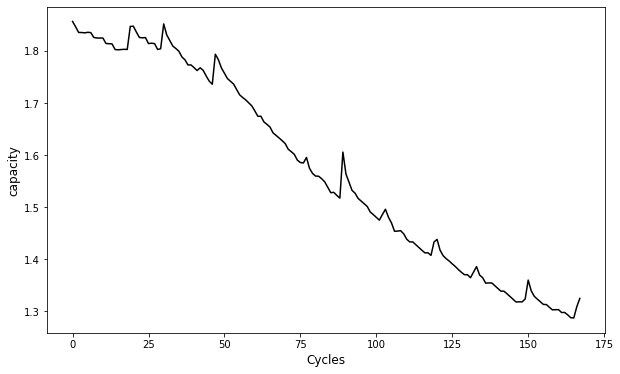

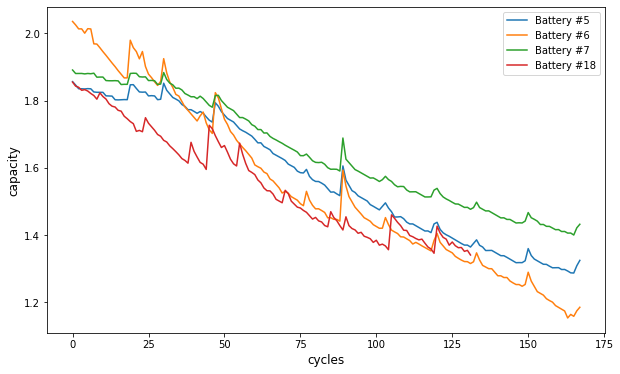

p-value of battery #5 is: 0.8869061026357303
p-value after differencing: 1.7041928511238572e-19
dif_5:
   capacity
1 -0.010160
2 -0.010978
3 -0.000087
4 -0.000617
5  0.001016
data after differencing and normalization
Dimension of train data:  (133, 1)
Dimension of test data:  (34, 1)
(123, 10, 1)
(24, 10, 1)
Epoch 1/200
13/13 [==============================] - 4s 75ms/step - loss: 0.0539 - val_loss: 0.0111
Epoch 2/200
13/13 [==============================] - 0s 13ms/step - loss: 0.0173 - val_loss: 0.0067
Epoch 3/200
13/13 [==============================] - 0s 13ms/step - loss: 0.0184 - val_loss: 0.0054
Epoch 4/200
13/13 [==============================] - 0s 13ms/step - loss: 0.0164 - val_loss: 0.0048
Epoch 5/200
13/13 [==============================] - 0s 12ms/step - loss: 0.0151 - val_loss: 0.0045
Epoch 6/200
13/13 [==============================] - 0s 12ms/step - loss: 0.0144 - val_loss: 0.0048
Epoch 7/200
13/13 [==============================] - 0s 13ms/step - loss: 0.0156 - val_los

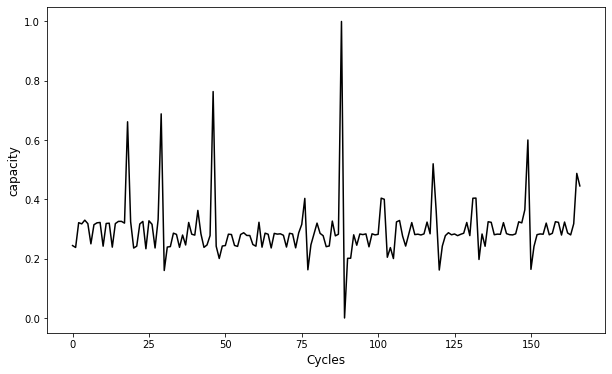

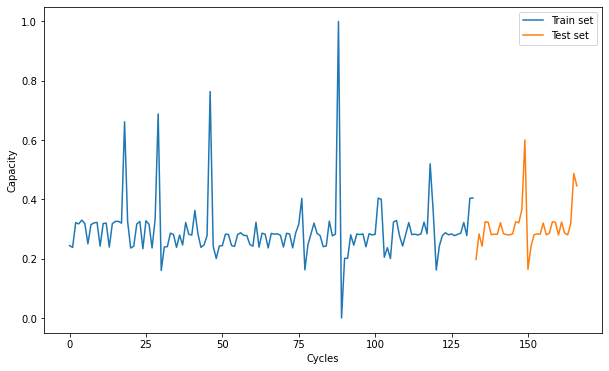

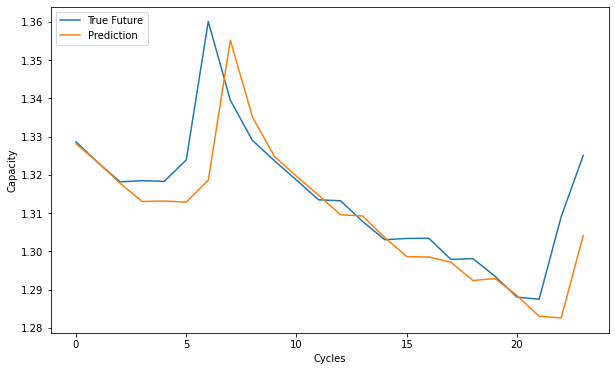

In [37]:
############## Complete example ###########
###### 1. Data processing
# 1.1 load data
# loading data test
# filename_5 = 'B0005_discharge.json'
# filename_6 = 'B0006_discharge.json'
# filename_7 = 'B0007_discharge.json'
# filename_18 = 'B0018_discharge.json'
# inre_features = ['date_time', 'voltage_battery', 'current_battery', 'temp_battery', 'amb_temp', 'current_load', 'voltage_load', 'time']
# capacity_df_5, _ = data_loading(filename_5, inre_features)
# capacity_df_6, _ = data_loading(filename_6, inre_features)
# capacity_df_7, _ = data_loading(filename_7, inre_features)
# capacity_df_18, _ = data_loading(filename_18, inre_features)

# def getValue(x):
#     return x[0]
# capacity_df_5['capacity'] = capacity_df_5['capacity'].map(getValue)
# capacity_df_6['capacity'] = capacity_df_6['capacity'].map(getValue)
# capacity_df_7['capacity'] = capacity_df_7['capacity'].map(getValue)
# capacity_df_18['capacity'] = capacity_df_18['capacity'].map(getValue)

# plot capacity_df_5
timeseries(capacity_df_5.index, capacity_df_5['capacity'], 'Cycles', 'capacity')

# plot multiple batteries
plt.figure(figsize=(10,6))
plt.plot(capacity_df_5.index, capacity_df_5['capacity'], label='Battery #5')
plt.plot(capacity_df_6.index, capacity_df_6['capacity'], label ='Battery #6')
plt.plot(capacity_df_7.index, capacity_df_7['capacity'], label = 'Battery #7')
plt.plot(capacity_df_18.index, capacity_df_18['capacity'], label = 'Battery #18')
plt.xlabel('cycles', {'fontsize':12})
plt.ylabel('capacity', {'fontsize':12})
plt.legend()
plt.show()

# process capacity_df_5
# 1.2 Transform the data into stationary
### detecting non_stationarity statistically
test_results = detect_stationarity(capacity_df_5["capacity"])
print(f"p-value of battery #5 is: {test_results[1]}")
dif_5 = transform_into_stationary(capacity_df_5)
test_results2 = detect_stationarity(dif_5["capacity"])
print(f"p-value after differencing: {test_results2[1]}")

print("dif_5:")
print(dif_5.head())

# 1.3 normalization (not use function -> need to use same scaler to inverse)
scaler = MinMaxScaler(feature_range=(0, 1))
input_scaler = scaler.fit(dif_5.values)
norm_data_5 = input_scaler.transform(dif_5.values)
norm_data_5 = pd.DataFrame(norm_data_5)


# plot the data after differencing and nommalization
norm_data_5.columns=['capacity']
print("data after differencing and normalization")
timeseries(norm_data_5.index, norm_data_5['capacity'], 'Cycles', 'capacity')

# 1.4 train-test splits
train_data_5, test_data_5 = divide_train_test(norm_data_5, split_fraction=0.8)

########################## Plotting dataset #######################

plt.figure(figsize = (10, 6))
plt.plot(train_data_5)
plt.plot(test_data_5)
plt.xlabel('Cycles')
plt.ylabel('Capacity')
plt.legend(['Train set', 'Test set'], loc='upper right')
print('Dimension of train data: ',train_data_5.shape)
print('Dimension of test data: ', test_data_5.shape)

#1.5 timeseries_dataset_preparation 
train_ds_5, train_data_X_5, train_data_Y_5 = timeseries_dataset_preparation(train_data_5, 10)
print(train_data_X_5.shape)
test_ds_5, test_data_X_5, test_data_Y_5 = timeseries_dataset_preparation(test_data_5, 10)
print(test_data_X_5.shape)


####### 2. Building Model 
model_lstm = create_model(16, train_data_X_5)
history_lstm = fit_model(model_lstm, train_data_X_5, train_data_Y_5)
model_lstm.summary()
#plot_loss(model_lstm)
train_data_Y_5 = scaler.inverse_transform(train_data_Y_5)
test_data_Y_5 = scaler.inverse_transform(test_data_Y_5)
#### prediction
prediction_lstm = prediction(model_lstm, test_data_X_5)

# print(test_data_Y.shape)
# print(prediction_lstm.shape)
# len_train = len(train_data_Y_5)
len = test_data_Y_5.size
observation = capacity_df_5[-1-len: -1]
predict = prediction_lstm + observation
y_test_5 = test_data_Y_5 + observation



plot_future(predict, y_test_5)

evaluate_prediction(predict, y_test_5, 'LSTM')


Text(0, 0.5, 'Capacity')

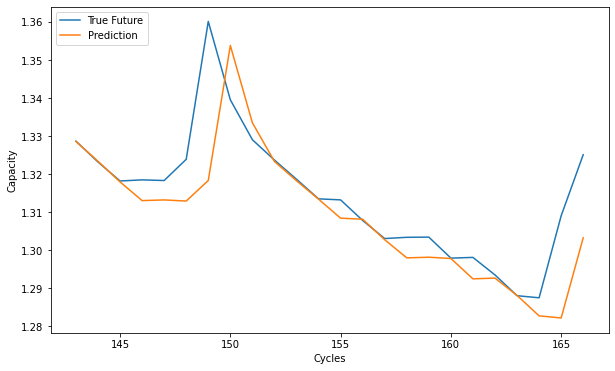

In [30]:
predict.index -= len_train
y_test_5.index -= len_train
plt.figure(figsize=(10, 6))
#range_future = predict.shape[0]
plt.plot(y_test_5, label='True Future')     
plt.plot(predict, label='Prediction')
plt.legend(loc='upper left')
plt.xlabel('Cycles')
plt.ylabel('Capacity')

## Multiple Train-Test Splits
This will require multiple models to be trained and evaluated, but this additional computational expense will provide a more robust estimate of the expected performance of the chosen method and configuration on unseen data.

You can see that the test size stays consistent. This means that performance statistis calculated on the predictions of each trained model will be consistent and can be combined and compared. It provides an apples-to-apples comparison.


Observations: 85
Training Observations: 44
Testing Observations: 41
Mean Absolute Error:  0.010003756784205373
Root Mean Square Error:  0.01393148774360457

...

Observations: 126
Training Observations: 85
Testing Observations: 41
Mean Absolute Error:  0.008795713521799852
Root Mean Square Error:  0.01354755391936248

...

Observations: 167
Training Observations: 126
Testing Observations: 41
Mean Absolute Error:  0.008132844621235055
Root Mean Square Error:  0.012546788931895985

...

This example shows the 3 splits and the growing number of total observations in each subsequent plot.

A limitation of the train-test split approach is that the trained models remain fixed as they are evaluated on each evaluation in the test set. 
-> This may not be realistic as models can be retrained as new daily or monthly observations are made avaliable. -> Walk Forward Validation.

In [65]:
# 1.2 Transform the data into stationary
### detecting non_stationarity statistically
test_results = detect_stationarity(capacity_df_6["capacity"])
print(f"p-value of battery #6 is: {test_results[1]}")
dif_6 = transform_into_stationary(capacity_df_6)
test_results2 = detect_stationarity(dif_6["capacity"])
print(f"p-value after differencing: {test_results2[1]}")
print("dif_6:")
print(dif_6.head())

# normalization (not use function -> need to use same scaler to inverse)
scaler = MinMaxScaler(feature_range=(0, 1))
input_scaler = scaler.fit(dif_6.values)
norm_data_6 = input_scaler.transform(dif_6.values)
type(norm_data_6)




p-value of battery #6 is: 0.5964018645995441
p-value after differencing: 4.031435741116703e-16
dif_6:
   capacity
1 -0.010197
2 -0.011814
3 -0.000042
4 -0.012756
5  0.013371


numpy.ndarray

Observations: 85
Training Observations: 44
Testing Observations: 41
Dimension of train data:  (44, 1)
Dimension of test data:  (41, 1)
(39, 5, 1)
(36, 5, 1)
Epoch 1/50
1/1 [==============================] - 4s 4s/step - loss: 0.0590 - val_loss: 0.0355
Epoch 2/50
1/1 [==============================] - 0s 43ms/step - loss: 0.0533 - val_loss: 0.0312
Epoch 3/50
1/1 [==============================] - 0s 47ms/step - loss: 0.0494 - val_loss: 0.0273
Epoch 4/50
1/1 [==============================] - 0s 40ms/step - loss: 0.0446 - val_loss: 0.0236
Epoch 5/50
1/1 [==============================] - 0s 44ms/step - loss: 0.0413 - val_loss: 0.0202
Epoch 6/50
1/1 [==============================] - 0s 50ms/step - loss: 0.0375 - val_loss: 0.0171
Epoch 7/50
1/1 [==============================] - 0s 44ms/step - loss: 0.0340 - val_loss: 0.0143
Epoch 8/50
1/1 [==============================] - 0s 46ms/step - loss: 0.0308 - val_loss: 0.0118
Epoch 9/50
1/1 [==============================] - 0s 40ms/step - loss

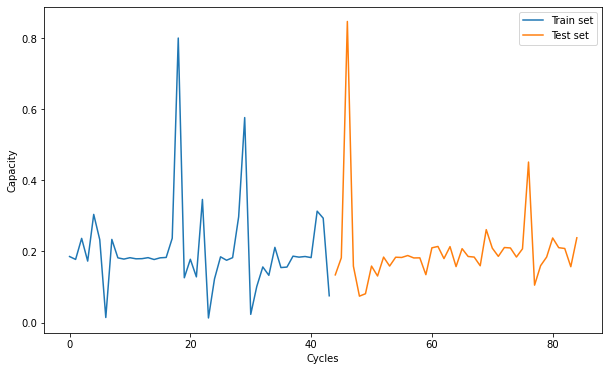

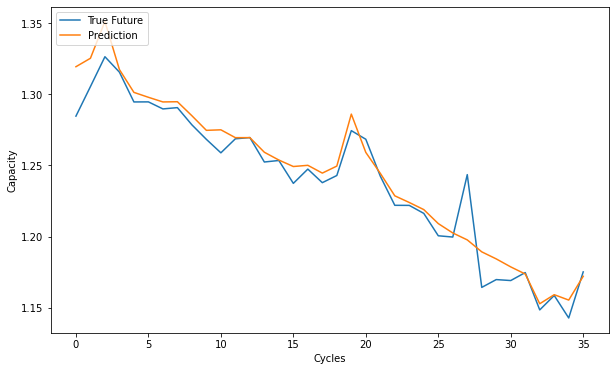

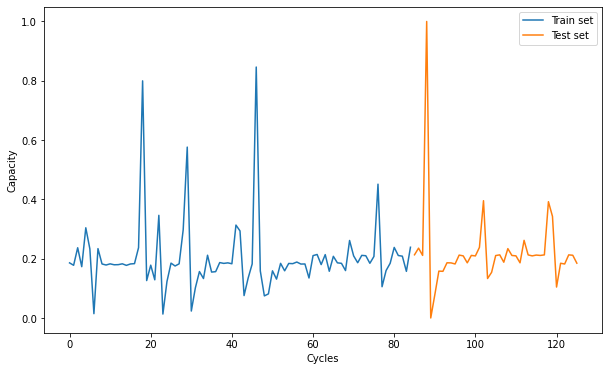

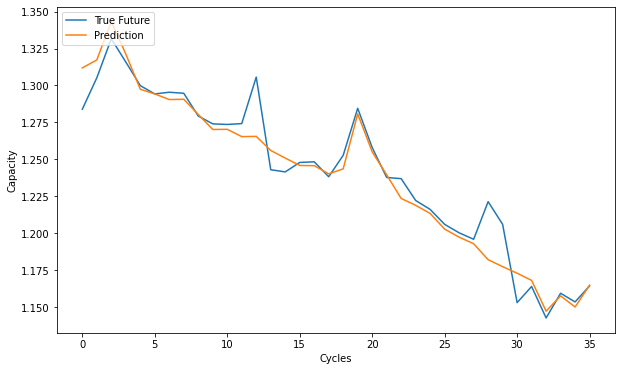

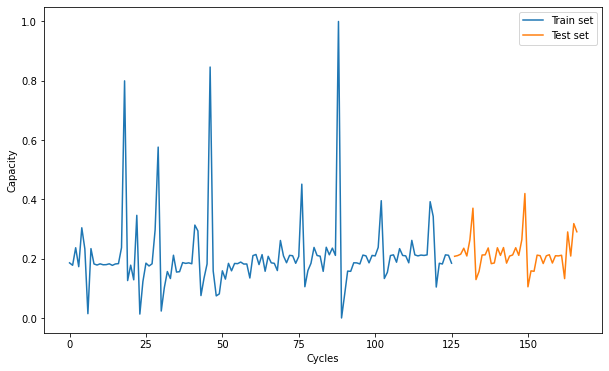

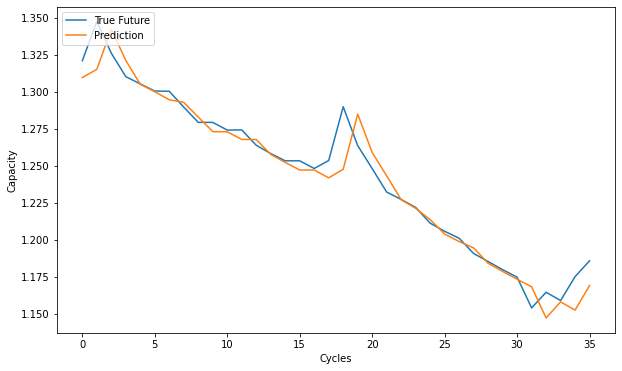

In [66]:

import numpy as np
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)
for train_index, test_index in tscv.split(norm_data_6):
    print('Observations: %d' % (train_index.size + test_index.size))
    print('Training Observations: %d' % (train_index.size))
    print('Testing Observations: %d' % (test_index.size))
    train_data_6, test_data_6 = divide_train_test_index(norm_data_6, train_index, test_index)
   
    ########################## Plotting dataset #######################
    plot_train_test(train_data_6, test_data_6)
    
    
    ### timeseries_dataset_preparation ###
    train_ds_6, train_data_X_6, train_data_Y_6 = timeseries_dataset_preparation(train_data_6, 5)
    print(train_data_X_6.shape)
    test_ds_6, test_data_X_6, test_data_Y_6 = timeseries_dataset_preparation(test_data_6, 5)
    print(test_data_X_6.shape)

    ####### 2. Building Model #######  
    model_lstm = create_model(16, train_data_X_6)
    history_lstm = fit_model(model_lstm, train_data_X_6, train_data_Y_6)
    model_lstm.summary()
    train_data_Y_6 = scaler.inverse_transform(train_data_Y_6)
    test_data_Y_6 = scaler.inverse_transform(test_data_Y_6)
    #### prediction ####### 
    prediction_lstm = prediction(model_lstm, test_data_X_6)

    len = test_data_Y_6.size
    observation = capacity_df_6[-1-len: -1]
    predict = prediction_lstm + observation
    y_test_6 = test_data_Y_6 + observation

    plot_future(predict, y_test_6)

    evaluate_prediction(predict, y_test_6, 'LSTM')
    

In [31]:
model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 10, 16)            1152      
                                                                 
 dropout_4 (Dropout)         (None, 10, 16)            0         
                                                                 
 lstm_5 (LSTM)               (None, 16)                2112      
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 3,281
Trainable params: 3,281
Non-trainable params: 0
_________________________________________________________________


### Use the battery#5 model to predict battery#7

p-value of battery #5 is: 0.8869061026357303
p-value after differencing: 1.7041928511238572e-19
dif_5:
   capacity
1 -0.010160
2 -0.010978
3 -0.000087
4 -0.000617
5  0.001016
data after differencing and normalization
Dimension of train data:  (133, 1)
Dimension of test data:  (34, 1)
(123, 10, 1)
(24, 10, 1)
Epoch 1/200
13/13 [==============================] - 5s 72ms/step - loss: 0.0674 - val_loss: 0.0123
Epoch 2/200
13/13 [==============================] - 0s 10ms/step - loss: 0.0188 - val_loss: 0.0054
Epoch 3/200
13/13 [==============================] - 0s 11ms/step - loss: 0.0149 - val_loss: 0.0059
Epoch 4/200
13/13 [==============================] - 0s 11ms/step - loss: 0.0149 - val_loss: 0.0045
Epoch 5/200
13/13 [==============================] - 0s 11ms/step - loss: 0.0138 - val_loss: 0.0046
Epoch 6/200
13/13 [==============================] - 0s 11ms/step - loss: 0.0145 - val_loss: 0.0048
Epoch 7/200
13/13 [==============================] - 0s 11ms/step - loss: 0.0148 - val_los

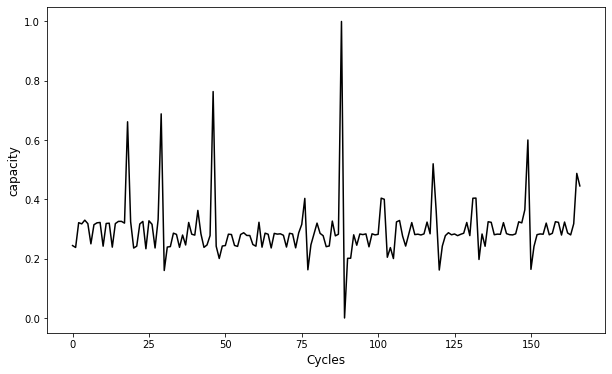

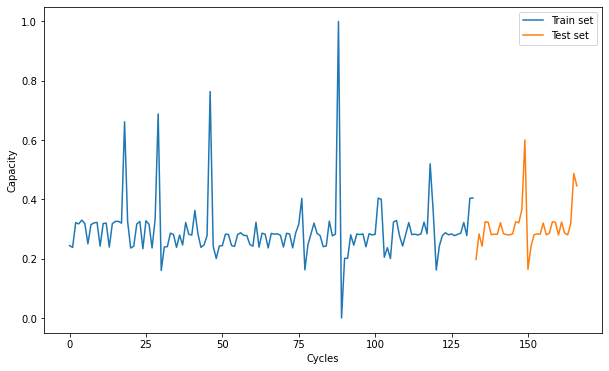

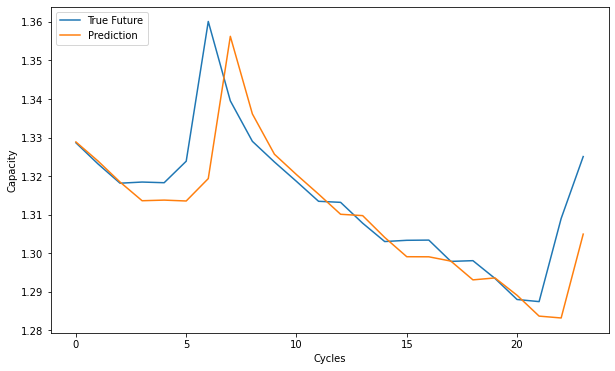

In [38]:
# process capacity_df_5
# 1.2 Transform the data into stationary
### detecting non_stationarity statistically
test_results = detect_stationarity(capacity_df_5["capacity"])
print(f"p-value of battery #5 is: {test_results[1]}")
dif_5 = transform_into_stationary(capacity_df_5)
test_results2 = detect_stationarity(dif_5["capacity"])
print(f"p-value after differencing: {test_results2[1]}")

print("dif_5:")
print(dif_5.head())

# 1.3 normalization (not use function -> need to use same scaler to inverse)
scaler = MinMaxScaler(feature_range=(0, 1))
input_scaler = scaler.fit(dif_5.values)
norm_data_5 = input_scaler.transform(dif_5.values)
norm_data_5 = pd.DataFrame(norm_data_5)


# plot the data after differencing and nommalization
norm_data_5.columns=['capacity']
print("data after differencing and normalization")
timeseries(norm_data_5.index, norm_data_5['capacity'], 'Cycles', 'capacity')

# 1.4 train-test splits
train_data_5, test_data_5 = divide_train_test(norm_data_5, split_fraction=0.8)

########################## Plotting dataset #######################

plt.figure(figsize = (10, 6))
plt.plot(train_data_5)
plt.plot(test_data_5)
plt.xlabel('Cycles')
plt.ylabel('Capacity')
plt.legend(['Train set', 'Test set'], loc='upper right')
print('Dimension of train data: ',train_data_5.shape)
print('Dimension of test data: ', test_data_5.shape)

#1.5 timeseries_dataset_preparation 
train_ds_5, train_data_X_5, train_data_Y_5 = timeseries_dataset_preparation(train_data_5, 10)
print(train_data_X_5.shape)
test_ds_5, test_data_X_5, test_data_Y_5 = timeseries_dataset_preparation(test_data_5, 10)
print(test_data_X_5.shape)


####### 2. Building Model 
model_lstm = create_model(32, train_data_X_5)
history_lstm = fit_model(model_lstm, train_data_X_5, train_data_Y_5)
model_lstm.summary()
train_data_Y_5 = scaler.inverse_transform(train_data_Y_5)
test_data_Y_5 = scaler.inverse_transform(test_data_Y_5)
#### prediction
prediction_lstm = prediction(model_lstm, test_data_X_5)

# print(test_data_Y.shape)
# print(prediction_lstm.shape)

len = test_data_Y_5.size
observation = capacity_df_5[-1-len: -1]
predict = prediction_lstm + observation
y_test_5 = test_data_Y_5 + observation

plot_future(predict, y_test_5)

evaluate_prediction(predict, y_test_5, 'LSTM')

data after differencing and normalization
(157, 10, 1)
LSTM:
Mean Absolute Error:  0.010571622462991915
Root Mean Square Error:  0.015807408184013515



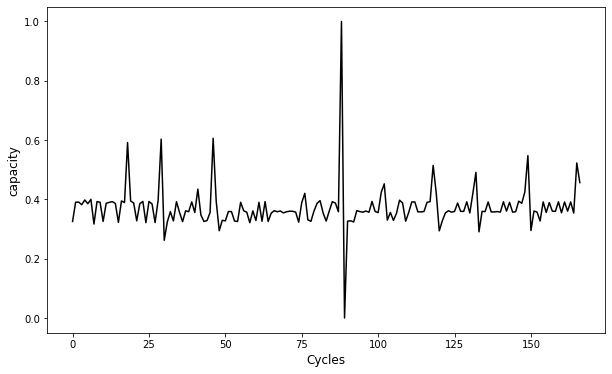

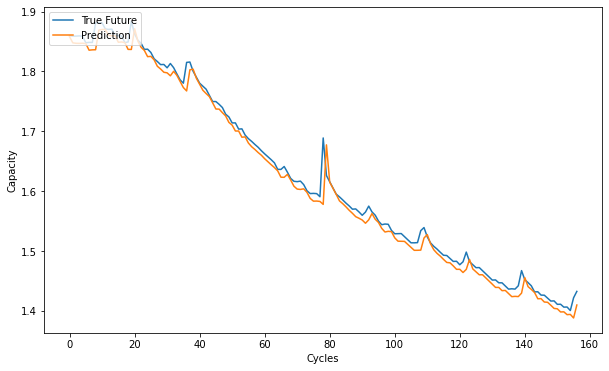

In [39]:
dif_7 = transform_into_stationary(capacity_df_7)
scaler = MinMaxScaler(feature_range=(0, 1))
input_scaler = scaler.fit(dif_7.values)
norm_data_7 = input_scaler.transform(dif_7.values)
norm_data_7 = pd.DataFrame(norm_data_7)
norm_data_7.columns=['capacity']
print("data after differencing and normalization")
timeseries(norm_data_7.index, norm_data_7['capacity'], 'Cycles', 'capacity')
test_ds_7, test_data_X_7, test_data_Y_7 = timeseries_dataset_preparation(norm_data_7, 10)
print(test_data_X_7.shape)

test_data_Y_7 = scaler.inverse_transform(test_data_Y_7)
prediction_lstm_7 = prediction(model_lstm, test_data_X_7)

len = test_data_Y_7.size
observation_7 = capacity_df_7[-1-len: -1]
predict_7 = prediction_lstm_7 + observation_7
y_test_7 = test_data_Y_7 + observation_7

plot_future(predict_7, y_test_7)

evaluate_prediction(predict_7, y_test_7, 'LSTM')

data after differencing and normalization
(121, 10, 1)
LSTM:
Mean Absolute Error:  0.02022488376036725
Root Mean Square Error:  0.025710636554179815



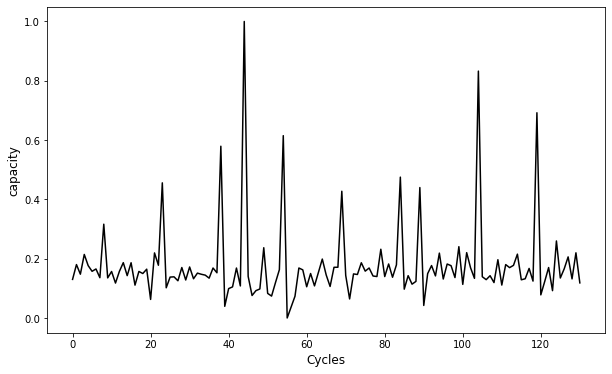

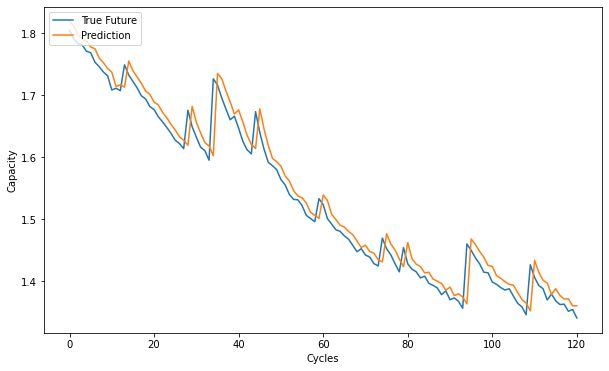

In [40]:
dif_18 = transform_into_stationary(capacity_df_18)
scaler = MinMaxScaler(feature_range=(0, 1))
input_scaler = scaler.fit(dif_18.values)
norm_data_18 = input_scaler.transform(dif_18.values)
norm_data_18 = pd.DataFrame(norm_data_18)
norm_data_18.columns=['capacity']
print("data after differencing and normalization")
timeseries(norm_data_18.index, norm_data_18['capacity'], 'Cycles', 'capacity')
test_ds_18, test_data_X_18, test_data_Y_18 = timeseries_dataset_preparation(norm_data_18, 10)
print(test_data_X_18.shape)

test_data_Y_18 = scaler.inverse_transform(test_data_Y_18)
prediction_lstm_18 = prediction(model_lstm, test_data_X_18)

len = test_data_Y_18.size
observation_18 = capacity_df_18[-1-len: -1]
predict_18 = prediction_lstm_18 + observation_18
y_test_18 = test_data_Y_18 + observation_18

plot_future(predict_18, y_test_18)

evaluate_prediction(predict_18, y_test_18, 'LSTM')

In [77]:
print(train_data_Y_5.shape)
print(test_data_Y_5.shape)


(123, 1)
(24, 1)


In [79]:
for train_index, test_index in tscv.split(norm_data_6):
    print('Observations: %d' % (train_index.size + test_index.size))
    print('Training Observations: %d' % (train_index.size))
    print('Testing Observations: %d' % (test_index.size))
    train_data_6, test_data_6 = divide_train_test_index(norm_data_6, train_index, test_index)
   

Observations: 85
Training Observations: 44
Testing Observations: 41
Observations: 126
Training Observations: 85
Testing Observations: 41
Observations: 167
Training Observations: 126
Testing Observations: 41
